In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
import matplotlib as mpl
import pyblock
from scipy.special import logsumexp
from scipy.special import softmax

# matplotlib settings
# --- Publication style settings ---
plt.rcParams.update({
    # Font
    "font.family": "Times New Roman",
    "font.serif": ["Arial"],  # or other preferred serif font
    "mathtext.fontset": "cm",            # Computer Modern for math text
    "text.usetex": False,                 # Use LaTeX for text rendering]
    "pdf.fonttype": 42,                 # Use LaTeX for text rendering

    # Figure
    "figure.figsize": (6, 4),            # width, height in inches
    "figure.dpi": 300,                   # high resolution

    # Axes
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "axes.linewidth": 1.2,
    "axes.grid": True,                   # optional, remove if you want no grid
    "grid.linestyle": "--",
    "grid.alpha": 0.7,

    # Ticks
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.top": True,
    "ytick.right": True,

    # Lines
    "lines.linewidth": 2,
    "lines.markersize": 6,

    # Legend
    "legend.fontsize": 10,
    "legend.frameon": False
})

def dssp_to_helicity(dssp_lines):
    """
    Convert DSSP strings into a binary helicity matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('H', 'G', 'I'), 0 = non-helix.
    """
    helix_codes = {'H', 'G', 'I'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

# Function to calculate per-residue PPII per frame
def dssp_to_PPII(dssp_lines):
    """
    Convert DSSP strings into a binary PPII matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = helix ('P'), 0 = non-helix.
    """
    helix_codes = {'P'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    helicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        helicity[i, :] = [1 if c in helix_codes else 0 for c in line]
    
    return helicity

def dssp_to_strand(dssp_lines):
    """
    Convert DSSP strings into a binary beta strand matrix.
    
    Parameters
    ----------
    dssp_lines : list of str
        Each entry corresponds to one frame.
        Each string is the DSSP assignment per residue for that frame.
    
    Returns
    -------
    helicity : np.ndarray
        Array of shape (n_frames, n_residues).
        1 = strand ('E', 'B'), 0 = non-strand.
    """
    strand_codes = {'E', 'B'}
    
    n_frames = len(dssp_lines)
    n_residues = len(dssp_lines[0])
    
    strandicity = np.zeros((n_frames, n_residues), dtype=int)
    
    for i, line in enumerate(dssp_lines):
        strandicity[i, :] = [1 if c in strand_codes else 0 for c in line]
    
    return strandicity

# paths
output_path = './plots_ACTR/'
prod_name = 'ACTR'
path = '../REST2/ACTR/PROD_REST2/'
path_biased = '../OPES_multiT/../OPES_multiT/ACTR/NEW_PRODUCTION_300K_2fs_80steps/alldata/'
opes_data_path = '../analysis/plots_ACTR/'

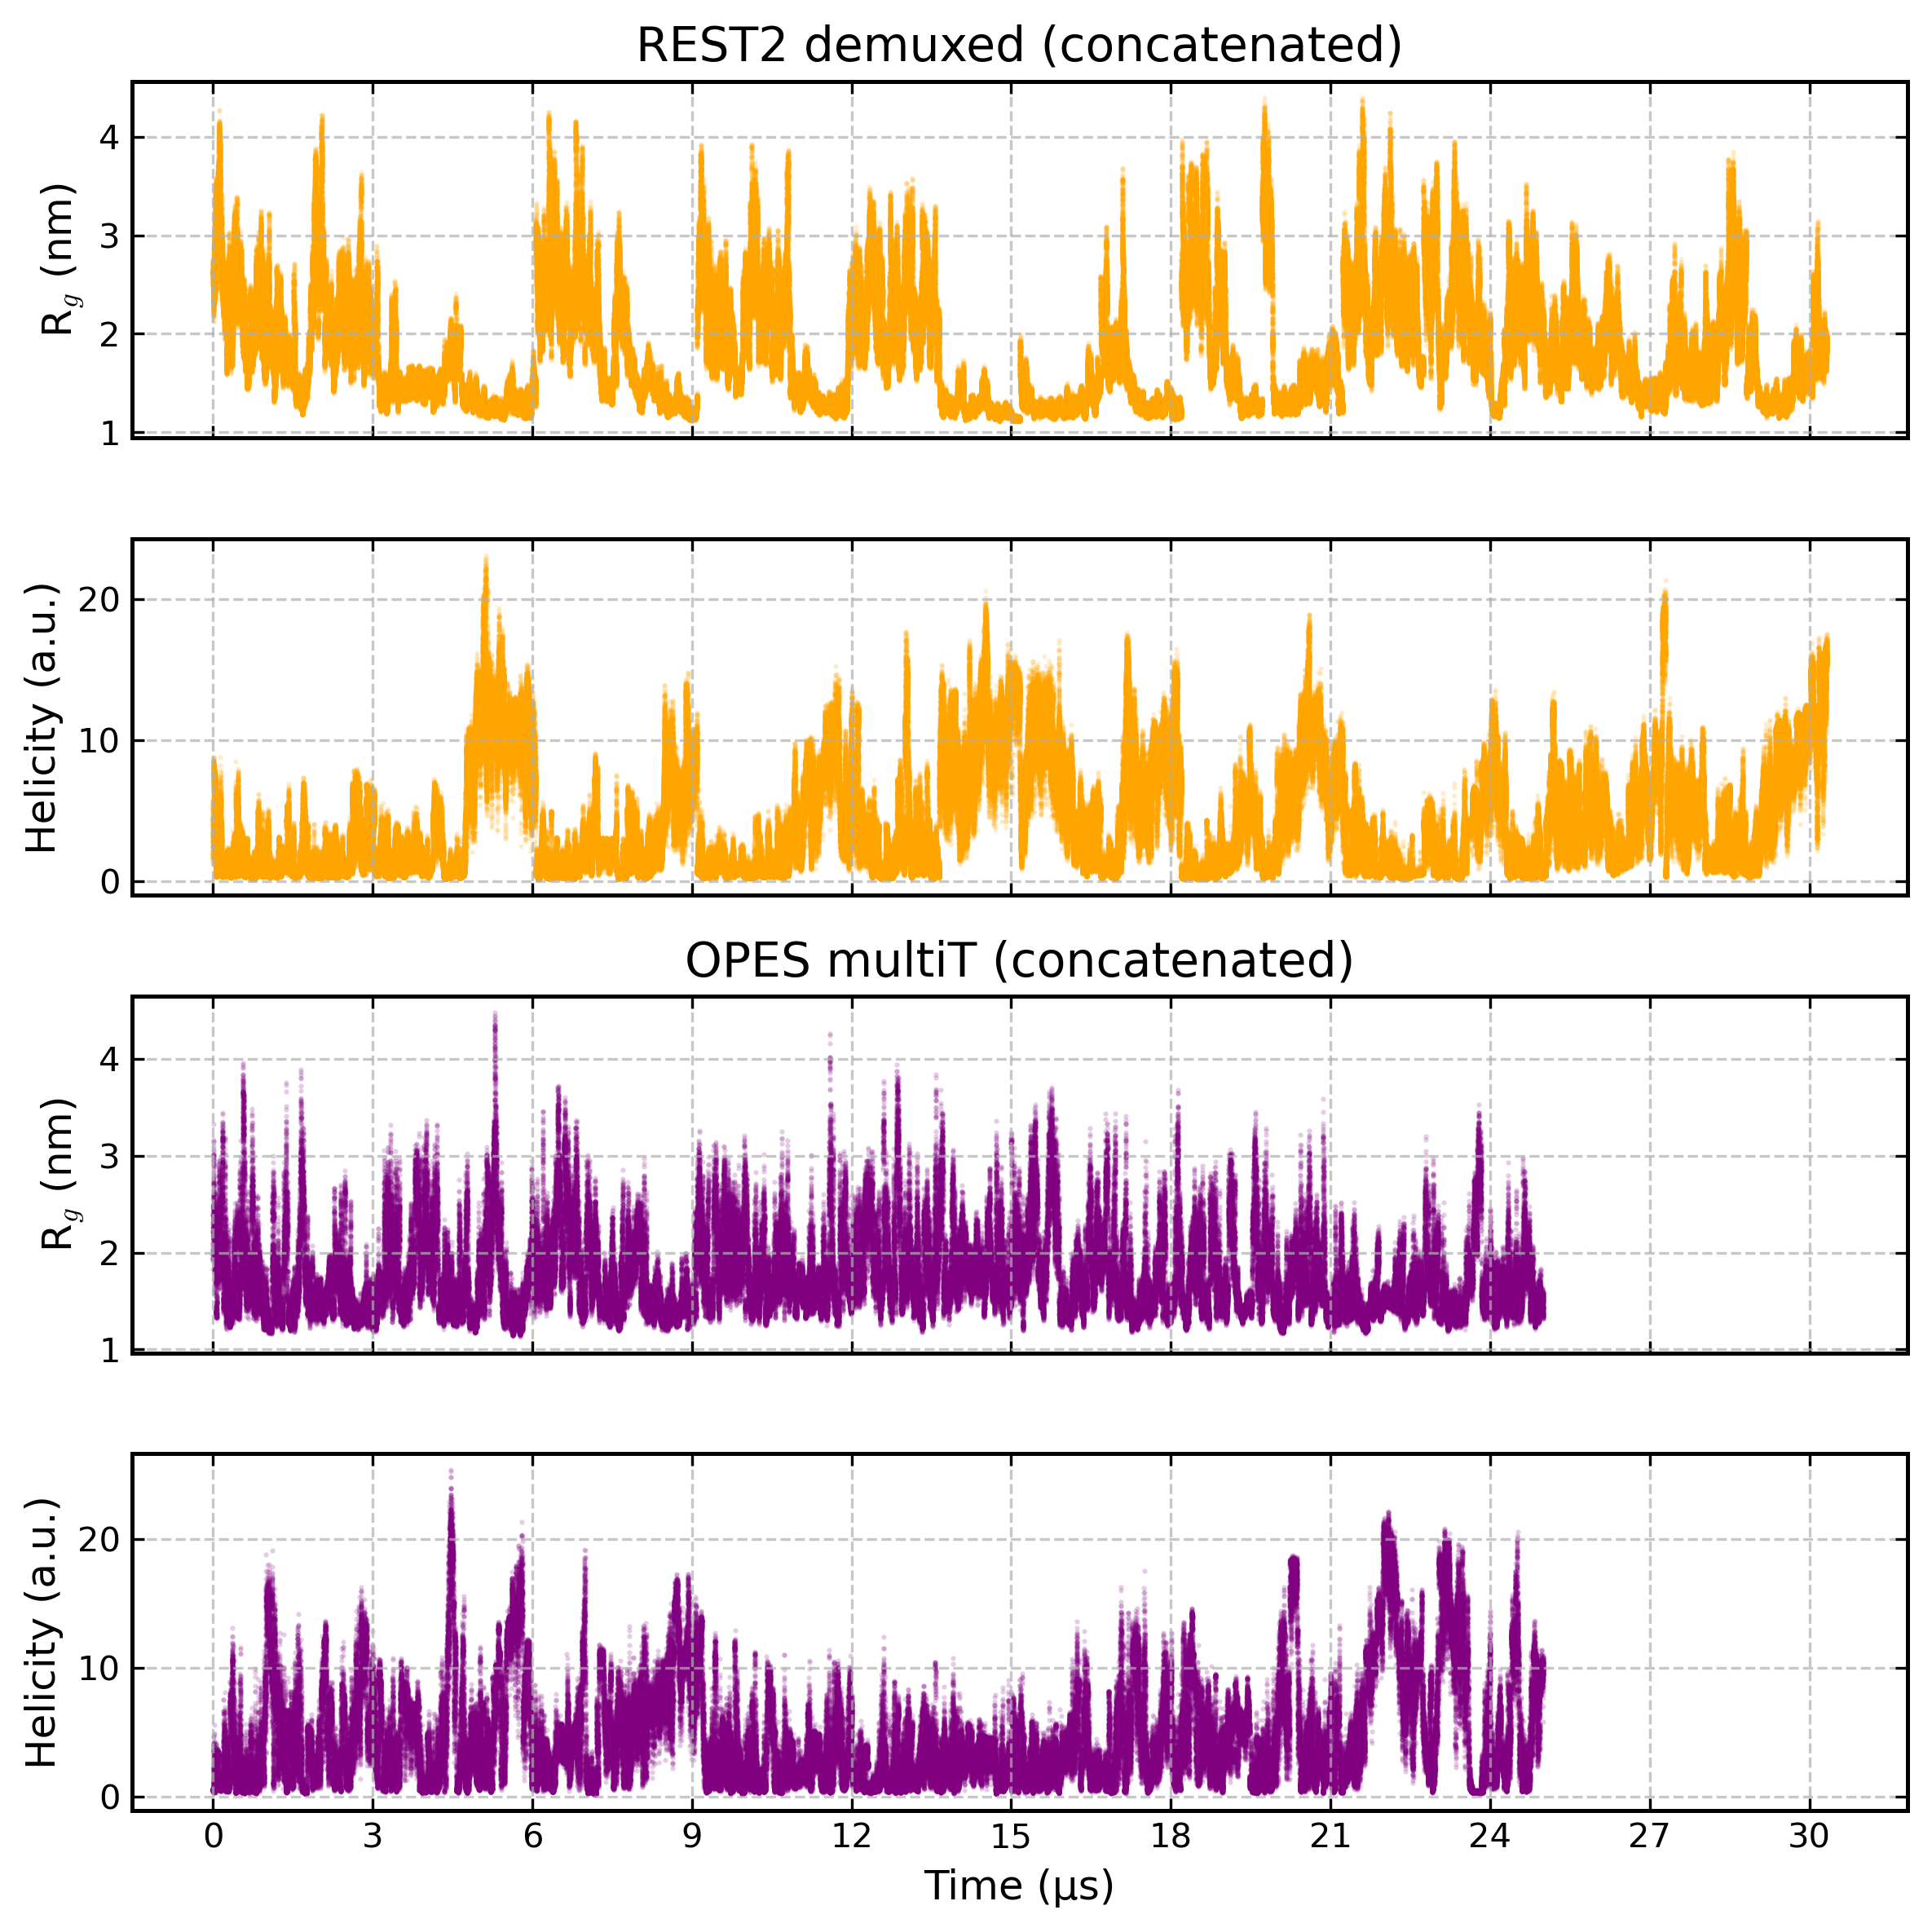

In [6]:
# plot all time evolutions of rg, alpharmsd


nsims_rest = 20
nsims_biased = 5
descriptors = ["R$_g$ (nm)", "alphaRMSD"]

fig, axes = plt.subplots(
    nrows=4, ncols=1, figsize=(8, 8), sharex="col", sharey="row"
)

for sim in range(nsims_rest):
    if sim==0:
        # Load data
        CVS = np.loadtxt(path+f'DEMUX/CVS_DATA.{sim}')
    else:
        tmpCVS = np.loadtxt(path+f'DEMUX/CVS_DATA.{sim}')
        CVS = np.concatenate((CVS, tmpCVS))
    # Time arrays in μs
    time_data = np.arange(CVS.shape[0]) * 40 /1e6
    # Apply cutoff at 40 µs
    mask_data = time_data <= 40.0 
    time_data = time_data[mask_data]
    CVS = CVS[mask_data]   

# Row 1: Rg
axes[0].scatter(time_data, CVS[:, 1], s=0.25, alpha=0.2, color = '#FFA500', rasterized=True)
axes[0].set_xticks([0, 3, 6, 9, 12, 15])
axes[0].set_xticklabels([0, 3, 6, 9, 12, 15])   
axes[0].set_ylabel("R$_g$ (nm)")

# Row 2: alphaRMSD
axes[1].scatter(time_data, CVS[:, 2], s=0.25, alpha=0.2, color = '#FFA500', rasterized=True)
axes[1].set_xticks([0, 3, 6, 9, 12, 15])
axes[1].set_xticklabels([0, 3, 6, 9, 12, 15])   
axes[1].set_ylabel("Helicity (a.u.)")

# Add column titles
axes[0].set_title(f"REST2 demuxed (concatenated)")

# biased data
for sim in range(nsims_biased):
    if sim==0:
        # Load data
        CVS = np.loadtxt(path_biased+f'CVS_DATA.{sim}')[::10] # downsample
        # Time arrays in μs
        time_data = np.arange(CVS.shape[0])/1e4
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        CVS = CVS[mask_data]
    else:
        tmpCVS = np.loadtxt(path_biased+f'CVS_DATA.{sim}')[::10] # downsample
        # Time arrays in μs
        time_data = np.arange(tmpCVS.shape[0])/1e4
        # Apply cutoff at 5 µs
        mask_data = time_data <= 5.0 
        tmpCVS = tmpCVS[mask_data]
        CVS = np.concatenate((CVS, tmpCVS))
     
time_data= np.arange(CVS.shape[0])/1e4

# Row 3: Rg
axes[2].scatter(time_data, CVS[:, 1], s=0.25, alpha=0.2, color = 'purple', rasterized=True)
axes[2].set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30])
axes[2].set_xticklabels([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30])   
axes[2].set_ylabel("R$_g$ (nm)")

# Row 4: alphaRMSD
axes[3].scatter(time_data, CVS[:, 2], s=0.25, alpha=0.2, color = 'purple', rasterized=True)
axes[3].set_xticks([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30])
axes[3].set_xticklabels([0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30])   
axes[3].set_ylabel("Helicity (a.u.)")
axes[3].set_xlabel("Time (μs)")

# Add column titles
axes[2].set_title(f"OPES multiT (concatenated)")

    

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_rg_alpha.pdf")



In [2]:
# average Rg at 300K

nsims = 1
T = 300

# initialise figure
plt.figure(figsize = (4,3))

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        CVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        # Time arrays in μs
        time_data = np.arange(CVS.shape[0]) * 40 /1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        CVS = CVS[mask_data]

    else:
        tmpCVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        # Time arrays in μs
        time_data = np.arange(tmpCVS.shape[0]) * 40 /1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        tmpCVS = tmpCVS[mask_data]
        CVS = np.concatenate((CVS, tmpCVS), axis=0)

# rg of concatenated trajs
rgdata = CVS[:,1]
print(rgdata.shape)

# run blocking analysis
reblock_data = pyblock.blocking.reblock(rgdata)
opt = pyblock.blocking.find_optimal_block(len(rgdata), reblock_data)[0]
print(opt)
mu = np.mean(rgdata)
std_err = reblock_data[opt][4]


# save data
df = pd.DataFrame()
df['Rg (nm)'] = [np.round(mu, 3)]
df['±'] = [np.round(std_err, 3)]
df.to_csv(output_path+f"{prod_name}_Rg_at_{T}K.csv",index=False)
df
        
    

(37911,)
11


,Rg (nm),±
0,2.046,0.036


<Figure size 1200x900 with 0 Axes>

sum probs: 1.0000000000000002


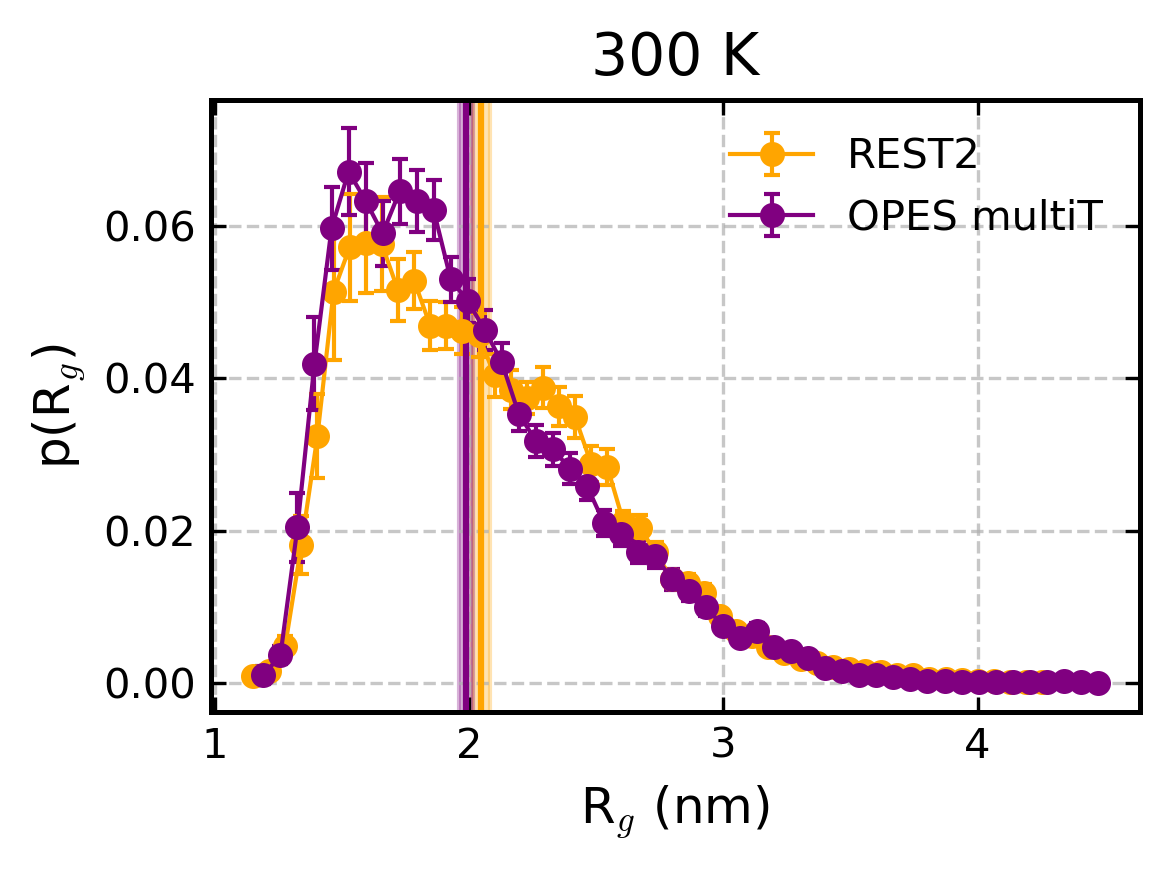

In [4]:
# Rg distribution at 300 K (avg ± std_err) and overlay with OPES multiT 300 K

nsims = 1
nbins = 50

# initialise figure
plt.figure(figsize = (4,3))

# load data and concatenate (and plot distributions of individual trajectories)
for sim in range(nsims):
    if sim==0:
        CVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        # Time arrays in μs
        time_data = np.arange(CVS.shape[0]) * 40 /1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        CVS = CVS[mask_data]

    else:
        tmpCVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        # Time arrays in μs
        time_data = np.arange(tmpCVS.shape[0]) * 40 /1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        tmpCVS = tmpCVS[mask_data]
        CVS = np.concatenate((CVS, tmpCVS), axis=0)

# rg of concatenated trajs
rgdata = CVS[:,1]

# histogram
counts, bin_edges = np.histogram(rgdata, bins=nbins, density=False)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
N = len(rgdata)

probs = np.zeros(nbins)
errs = np.zeros(nbins)

# for each bin build indicator time series and use pyblock
for i in range(nbins):
    left, right = bin_edges[i], bin_edges[i+1]
    # include left edge, exclude right edge except for last bin:
    if i == nbins-1:
        indicator = ((rgdata >= left) & (rgdata <= right)).astype(float)
    else:
        indicator = ((rgdata >= left) & (rgdata < right)).astype(float)

    # if the indicator is constant (no hits or all hits) handle trivially
    if indicator.sum() == 0:
        probs[i] = 0.0
        errs[i] = 0.0
        continue
    if indicator.sum() == N:
        probs[i] = 1.0
        errs[i] = 0.0
        continue

    # run pyblock: reblock returns list-like, find_optimal_block returns index (float -> convert)
    reblocked = pyblock.blocking.reblock(indicator)  # default no weights
    opt = int(pyblock.blocking.find_optimal_block(len(indicator), reblocked)[0])
    mean_bin = np.mean(indicator)
    stderr_bin = reblocked[opt].std_err

    probs[i] = mean_bin
    errs[i] = stderr_bin

# sanity: probabilities should sum approx to 1 (if using counts-->probs per-bin)
print("sum probs:", probs.sum())

# save data
df= pd.DataFrame()
df['Rg (nm)'] = bin_centers
df['p(Rg)'] = probs
df['±'] = errs
df.to_csv(output_path+f"{prod_name}_prob_Rg.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"300 K")
plt.errorbar(bin_centers, probs, yerr=errs, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='#FFA500', label='REST2')
plt.xlabel("R$_g$ (nm)")
plt.ylabel("p(R$_g$)")

# add OPES multi-T data as a comparison
dfopes = pd.read_csv(opes_data_path+f"300K_prob_Rg_300K.csv")
plt.errorbar(dfopes['Rg (nm)'], dfopes['p(Rg)'], yerr=dfopes['±'], fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple', label = 'OPES multiT')

# load and plot the average rg
avg1 = pd.read_csv(output_path+f"{prod_name}_Rg_at_300K.csv")
avg2 = pd.read_csv(opes_data_path+f"300K_Rg_at_300K.csv")

plt.axvline(avg1['Rg (nm)'][0], color = '#FFA500', linewidth=1.5)
plt.axvspan(avg1['Rg (nm)'][0]-avg1['±'][0],avg1['Rg (nm)'][0]+avg1['±'][0], color = '#FFA500', alpha=0.3)
plt.axvline(avg2['Rg (nm)'][0], color = 'purple', linewidth=1.5)
plt.axvspan(avg2['Rg (nm)'][0]-avg2['±'][0],avg2['Rg (nm)'][0]+avg2['±'][0], color = 'purple', alpha=0.3)

plt.legend()

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_prob_Rg.pdf")

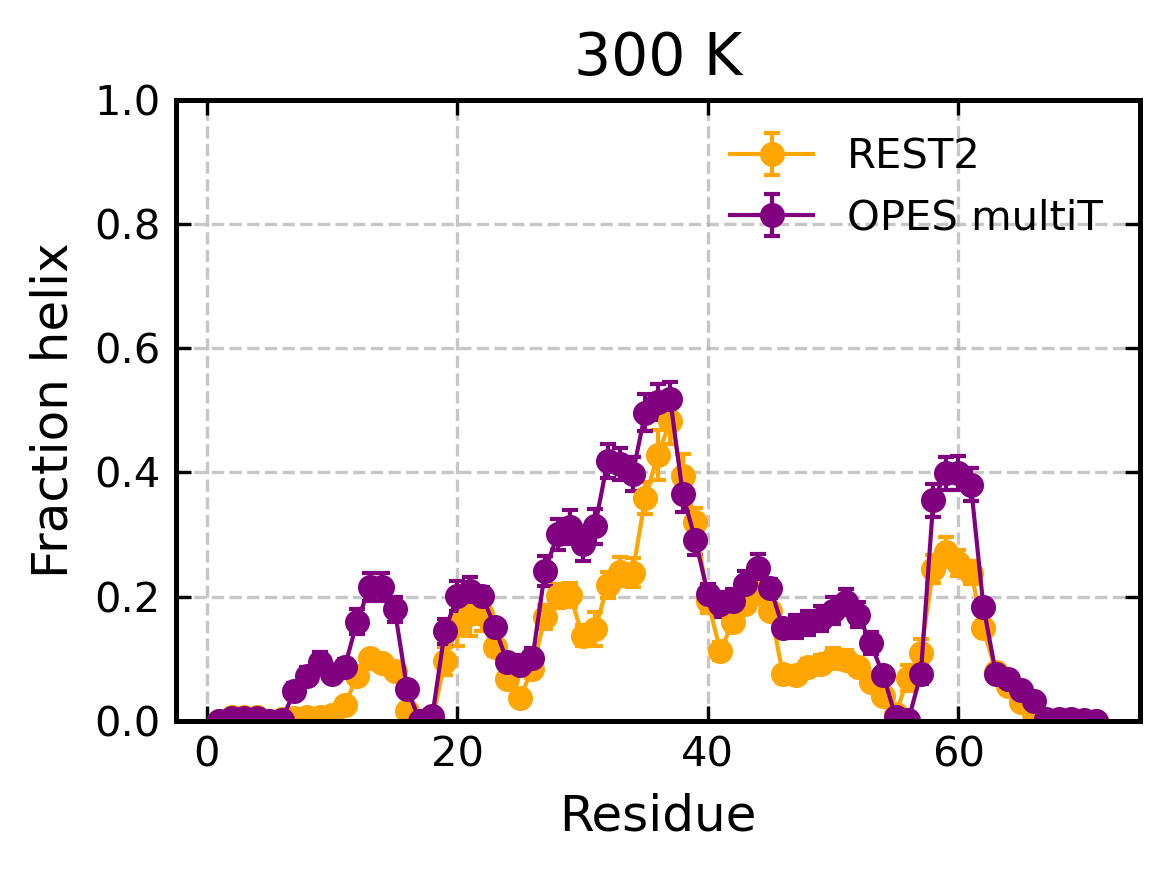

In [7]:
# Helicity at 300 K

nsims = 1
residues = np.arange(1, 71+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        with open(path+f'dir{sim}/dssp.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(dssp))*40/1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        dssp =  np.array(dssp)[mask_data]

    else:
        with open(path+f'dir{sim}/dssp.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(tmpdssp))*40/1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        tmpdssp = np.array(tmpdssp)[mask_data]
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        
# helicity for all, concatenated frames
H = dssp_to_helicity(dssp)

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = H[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.mean(series)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues
df['Fraction helix'] = means
df['±'] = stderr
df.to_csv(output_path+f"{prod_name}_perres_helicity.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"300 K")
plt.errorbar(residues, means, yerr=stderr, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='#FFA500', label='REST2')
plt.xlabel("Residue")
plt.ylabel("Fraction helix")

# overlay OPES multiT for a comparison
dfopes = pd.read_csv(opes_data_path+'300K_perres_helicity_300K.csv')
plt.errorbar(dfopes['Residue'], dfopes['Fraction helix'], yerr=dfopes['±'], fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple', label='OPES multiT')
plt.ylim(0,1.)

plt.legend()

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_helicity.pdf")

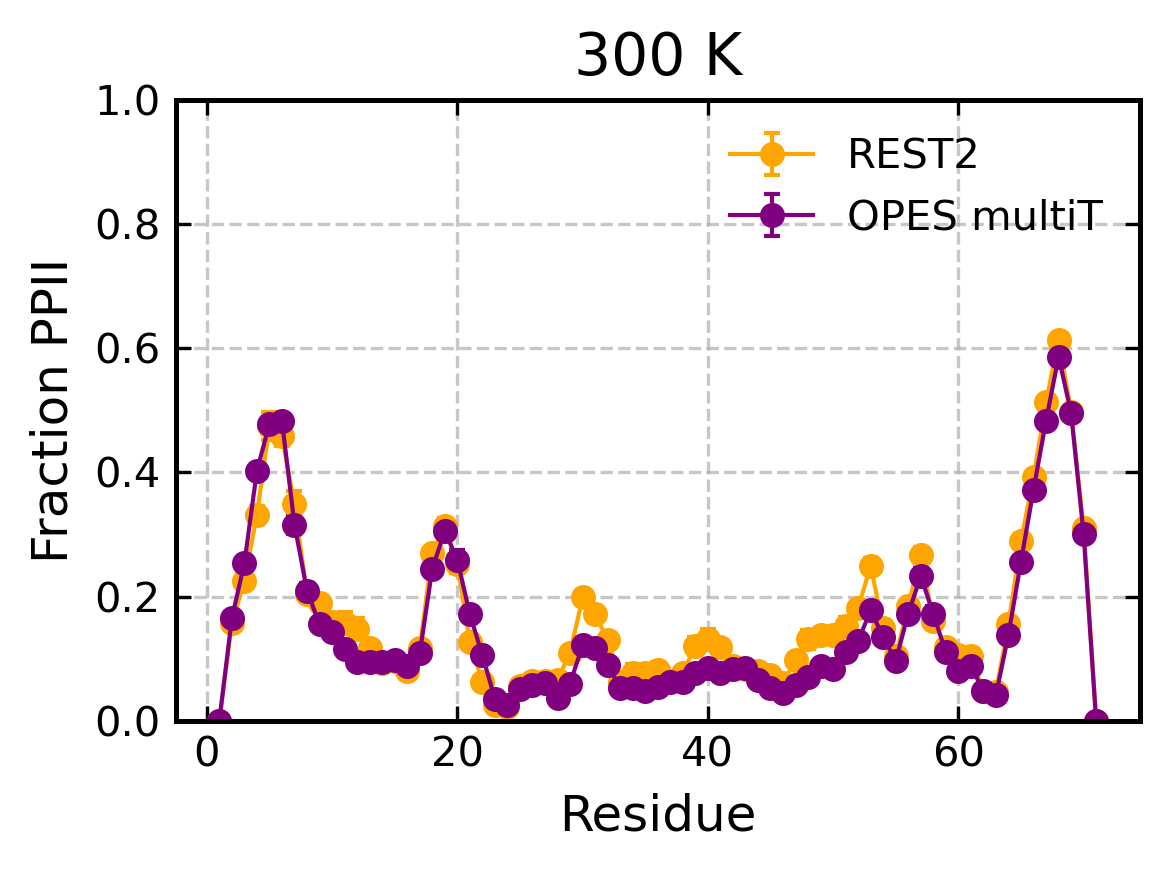

In [8]:
# PPII at 300 K

nsims = 1
residues = np.arange(1, 71+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        with open(path+f'dir{sim}/dssp.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(dssp))*40/1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        dssp =  np.array(dssp)[mask_data]

    else:
        with open(path+f'dir{sim}/dssp.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(tmpdssp))*40/1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        tmpdssp = np.array(tmpdssp)[mask_data]
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        
# helicity for all, concatenated frames
H = dssp_to_PPII(dssp)

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = H[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.mean(series)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues
df['Fraction helix'] = means
df['±'] = stderr
df.to_csv(output_path+f"{prod_name}_perres_PPII.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"300 K")
plt.errorbar(residues, means, yerr=stderr, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='#FFA500', label='REST2')
plt.xlabel("Residue")
plt.ylabel("Fraction PPII")

# overlay OPES multiT for a comparison
dfopes = pd.read_csv(opes_data_path+'300K_perres_PPII_300K.csv')
plt.errorbar(dfopes['Residue'], dfopes['Fraction helix'], yerr=dfopes['±'], fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple', label='OPES multiT')
plt.ylim(0,1.)

plt.legend()

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_PPII.pdf")

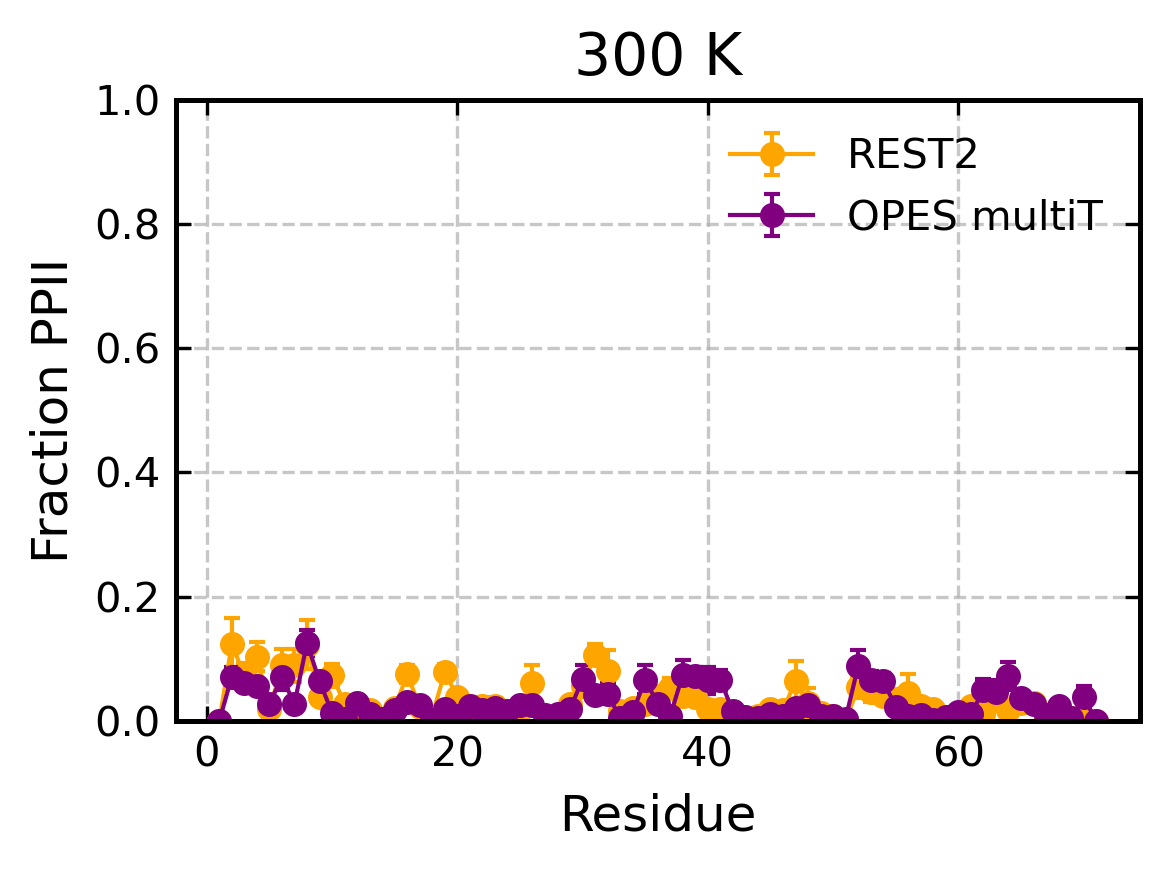

In [9]:
# strand propensity at 300 K

nsims = 1
residues = np.arange(1, 71+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        with open(path+f'dir{sim}/dssp.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(dssp))*40/1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        dssp =  np.array(dssp)[mask_data]

    else:
        with open(path+f'dir{sim}/dssp.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(tmpdssp))*40/1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        tmpdssp = np.array(tmpdssp)[mask_data]
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

        
# helicity for all, concatenated frames
S = dssp_to_strand(dssp)

# H: shape (n_frames, n_residues)
n_frames, n_residues = H.shape

means = np.zeros(n_residues)
stderr = np.zeros(n_residues)

for j in range(n_residues):
    series = S[:, j]  # helicity time series for residue j
    if np.mean(series)==0:
        means[j] = float(0)
        stderr[j] = float(0)
        continue
    reblock_data = pyblock.blocking.reblock(series)
    optimal = int(pyblock.blocking.find_optimal_block(len(series), reblock_data)[0])
    means[j] = np.mean(series)
    stderr[j] = reblock_data[optimal].std_err

# save data
df= pd.DataFrame()
df['Residue'] = residues
df['Fraction strand'] = means
df['±'] = stderr
df.to_csv(output_path+f"{prod_name}_perres_bstrand.csv", index=False)

# plot PMF with blocking error bars
plt.title(f"300 K")
plt.errorbar(residues, means, yerr=stderr, fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='#FFA500', label='REST2')
plt.xlabel("Residue")
plt.ylabel("Fraction PPII")

# overlay OPES multiT for a comparison
dfopes = pd.read_csv(opes_data_path+'300K_perres_bstrand_300K.csv')
plt.errorbar(dfopes['Residue'], dfopes['Fraction strand'], yerr=dfopes['±'], fmt='o-', markersize=5, capsize=2, linewidth=1., elinewidth=1., color='purple', label='OPES multiT')
plt.ylim(0,1.)

plt.legend()

plt.tight_layout()
plt.savefig(output_path+f"{prod_name}_perres_bstrand.pdf")

<Figure size 1200x900 with 0 Axes>

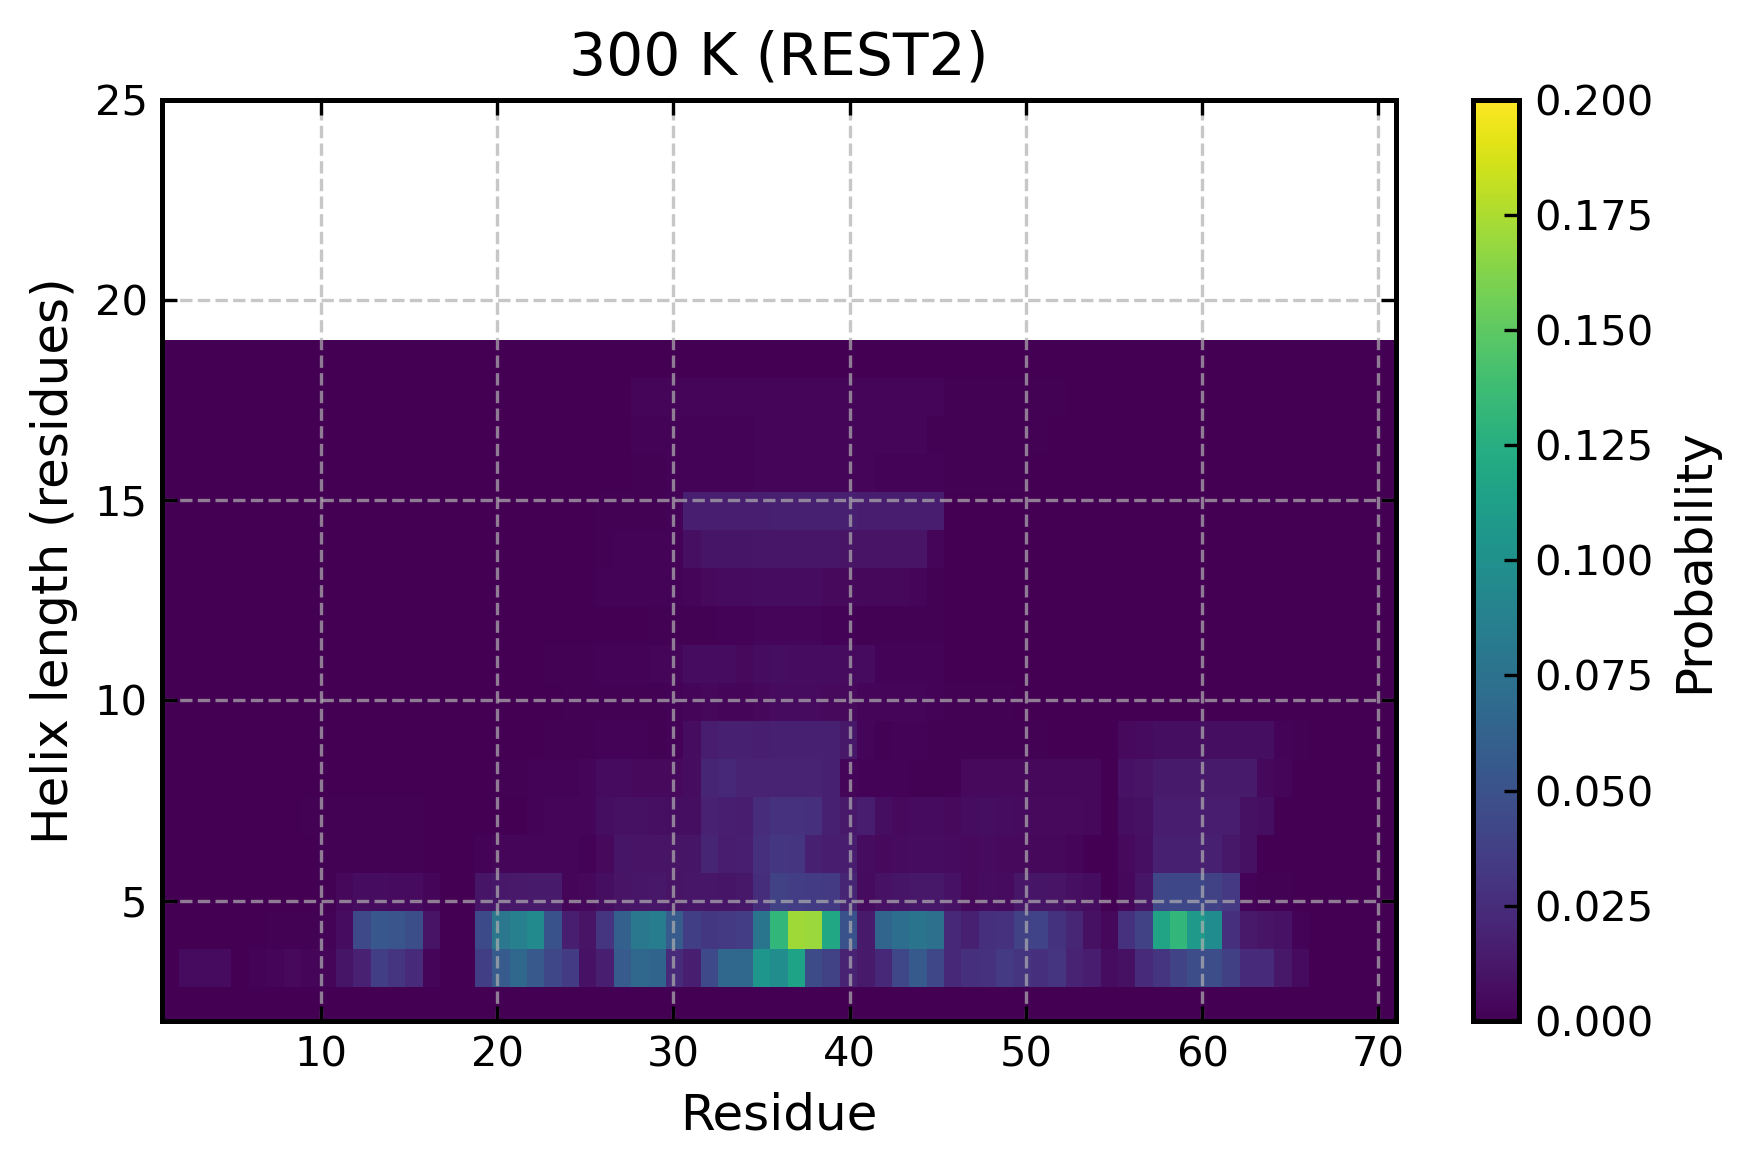

In [13]:
# 2D map: helix length vs residues 

nsims = 1
residues = np.arange(1, 71+1)

# initialise the figure

plt.figure(figsize = (4,3))

# load data and concatenate (and plot individual profiles)
for sim in range(nsims):
    if sim==0:
        with open(path+f'dir{sim}/dssp.dat') as f:
            dssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(dssp))*40/1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        dssp =  np.array(dssp)[mask_data]

    else:
        with open(path+f'dir{sim}/dssp.dat') as f:
            tmpdssp = [line.strip() for line in f]
        # Time arrays in μs
        time_data = np.arange(len(tmpdssp))*40/1e6
        # Apply cutoff at 2 µs
        mask_data = time_data <= 2.0 
        tmpdssp = np.array(tmpdssp)[mask_data]
        dssp = np.concatenate((dssp, tmpdssp), axis=0)

# Convert DSSP codes to helix map: H=1, G=1, I=1, else 0
def dssp_to_helix_binary(dssp_lines):
    helix_codes = {'H', 'G', 'I'}
    arr = np.zeros((len(dssp_lines), len(residues)), dtype=int)
    for i, line in enumerate(dssp_lines):
        arr[i, :] = [1 if c in helix_codes else 0 for c in line]
    return arr

weights_clean = np.ones(dssp.shape[0]) / dssp.shape[0]
H = dssp_to_helix_binary(dssp)
n_frames, n_residues = H.shape

# Compute helix segment lengths per residue per frame
helix_lengths = np.zeros_like(H, dtype=int)
for i in range(n_frames):
    j = 0
    while j < n_residues:
        if H[i, j] == 1:
            # start of helix segment
            start = j
            while j < n_residues and H[i, j] == 1:
                j += 1
            seglen = j - start
            helix_lengths[i, start:j] = seglen
        else:
            j += 1

# Determine maximum helix length
max_len = np.max(helix_lengths)

# 2D probability map: length (y) vs residue (x)
prob_map = np.zeros((max_len + 1, n_residues))  # include length=0 for non-helical

for j in range(n_residues):
    for i in range(n_frames):
        L = helix_lengths[i, j]
        prob_map[L, j] += weights_clean[i]

# Normalize columns to get probabilities
prob_map /= prob_map.sum(axis=0, keepdims=True)

# Plot
plt.figure(figsize=(6, 4))
plt.imshow(prob_map, origin='lower', aspect='auto', cmap='viridis',
           extent=[1, n_residues, 0, max_len])
plt.clim(0,0.2)
plt.ylim(2,25)
plt.colorbar(label='Probability')
plt.xlabel('Residue')
plt.ylabel('Helix length (residues)')
plt.title(f'300 K (REST2)')
plt.tight_layout()
plt.savefig(output_path + f"{prod_name}_helix_length_map_300K.pdf")



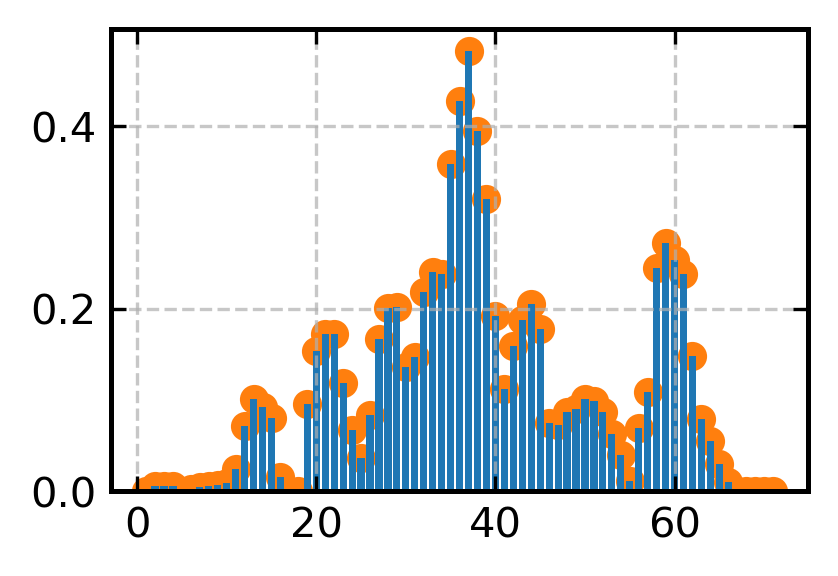

In [14]:
# sanity check that 2D map helix length vs residue correct and returns the same fraction helix per residue
df = pd.read_csv(output_path+f'{prod_name}_perres_helicity.csv')
plt.figure(figsize = (3,2))
plt.bar(residues, prob_map[1:].sum(axis=0))
plt.scatter(df['Residue'], df['Fraction helix'])

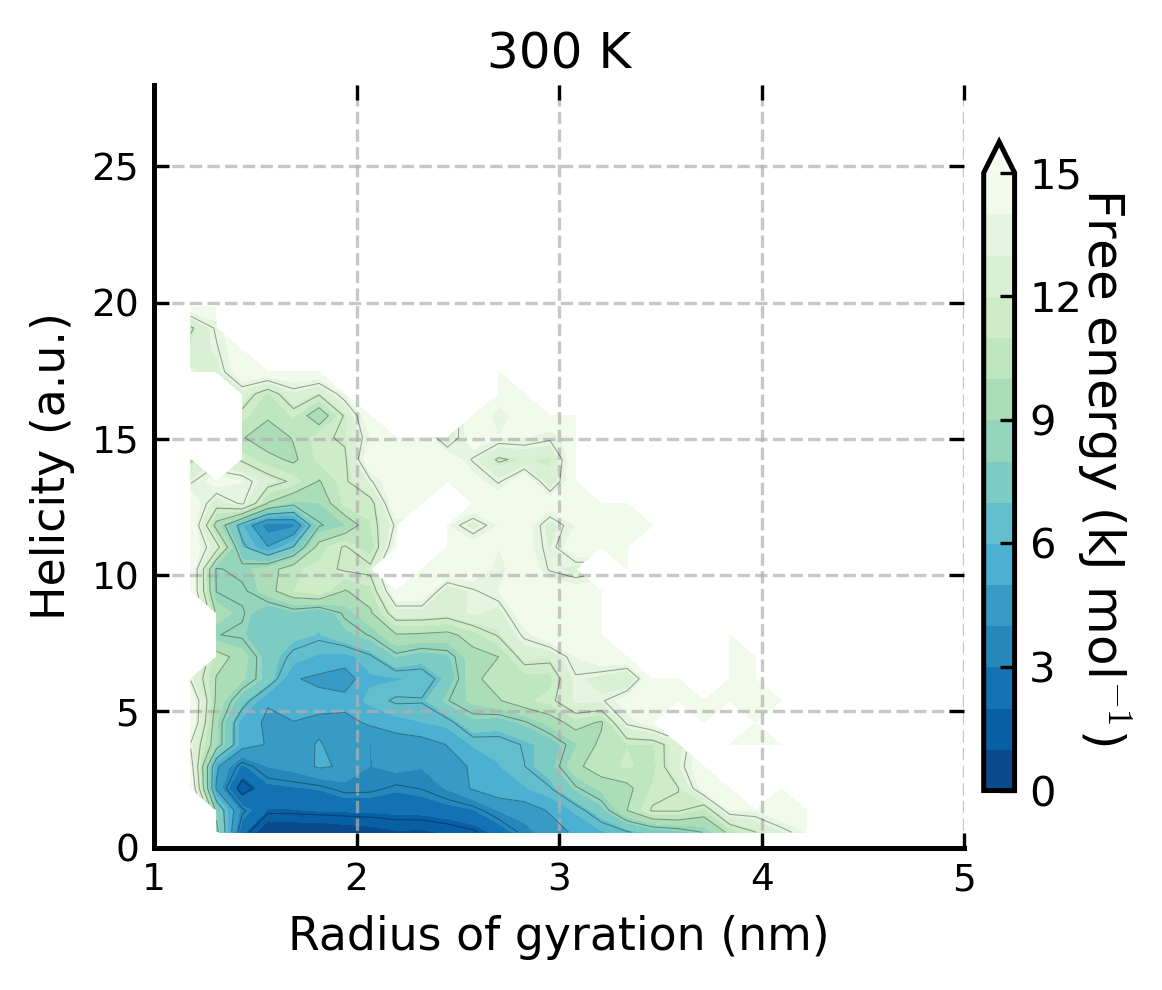

In [3]:
# 2D Map: Rg vs alphaRMSD at 300 K
max_FEL = 15
kb=0.008314
T0 = 300
T = 300
kbt = kb*T0
nsims_unbiased = 1

for sim in range(nsims_unbiased):
    if sim==0:
        # Load data
        CVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
    else:
        tmpCVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        CVS = np.concatenate((CVS, tmpCVS))
    # Time arrays in μs
    time_data = np.arange(CVS.shape[0])*40/1e6

# extract CVs
time_data = np.arange(CVS.shape[0])*40/1e6
mask_data = time_data <= 2.0 
rg = CVS[:,1][mask_data]
alphaRMSD = CVS[:,2][mask_data]

# --- Compute 2D histogram ---
nbins = 25
H, xedges, yedges = np.histogram2d(rg, alphaRMSD, bins=nbins, density=True)

# Avoid zeros for log
H[H <= 1e-15] = np.nan

# Convert probability to free energy (kJ/mol)
F = -kbt * np.log(H)
F = F - np.nanmin(F)  # shift minimum to 0

# Cap free energy to max FEL value
F[F > max_FEL] = max_FEL

# --- Grid centers for plotting ---
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])

# --- Pastel color map ---
cmap = plt.cm.viridis  # you can also try 'cividis', 'Spectral_r', or 'plasma'
from matplotlib.colors import LinearSegmentedColormap
pastel_cmap = LinearSegmentedColormap.from_list(
    "pastel_viridis", [plt.cm.viridis(0.1), plt.cm.viridis(0.6), plt.cm.viridis(0.9)], N=256
)

# plot

plt.figure(figsize=(4.0, 3.4), dpi=300)

# Smoother and fewer contour levels
levels = np.linspace(0, max_FEL, 16)

# Main contour plot
contour = plt.contourf(
    xcenters, ycenters, F.T,
    levels=levels,
    cmap='GnBu_r',
    extend='max'
)

for c in contour.collections:
    c.set_rasterized(True)

# --- Clean, sparse colorbar ---
cbar = plt.colorbar(contour, pad=0.02, shrink=0.85)
cbar.set_label(r"Free energy (kJ mol$^{-1}$)", rotation=270, labelpad=12)

# Fewer ticks (natural nice breakpoints)
cbar_ticks = np.linspace(0, max_FEL, 6)
cbar.set_ticks(cbar_ticks)

# --- Add subtle contour lines ---
plt.contour(
    xcenters, ycenters, F.T,
    levels=np.linspace(0, max_FEL, 10),
    colors='k',
    linewidths=0.25,
    alpha=0.35
)

# --- Refined axes ---
plt.xlabel(r"Radius of gyration (nm)", fontsize=11)
plt.ylabel("Helicity (a.u.)", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Light padding
plt.xlim(1, 5)
plt.ylim(0, 28)

# Remove top & right spines (cleaner look)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.title(f"{T} K", fontsize=12, pad=4)

plt.tight_layout()

plt.savefig(output_path + f"{prod_name}_2D_Rg_vs_alphaRMSD.pdf",
            dpi=300, bbox_inches='tight')

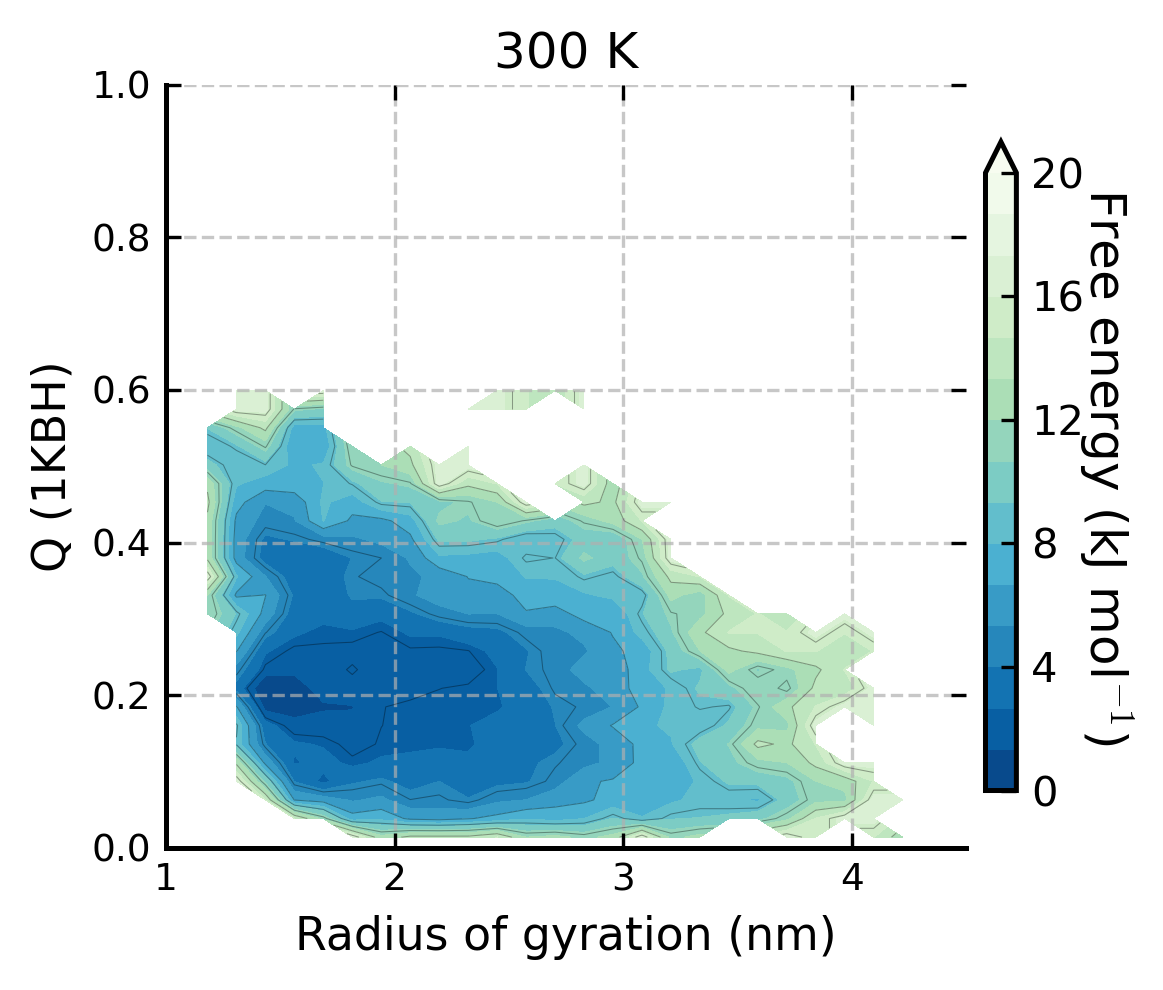

In [9]:
# 2D Map: Rg vs Q at 300 K
max_FEL = 20
kb=0.008314
T0 = 300
T = 300
kbt = kb*T0
nsims_unbiased = 1

for sim in range(nsims_unbiased):
    if sim==0:
        # Load data
        CVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        Q = np.loadtxt(path+f'native_contacts/Q{sim}.dat')
    else:
        tmpCVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        tmpQ = np.loadtxt(path+f'native_contacts/Q{sim}.dat')
        CVS = np.concatenate((CVS, tmpCVS))
        Q = np.concatenate((Q, tmpQ))
    # Time arrays in μs
    time_data = np.arange(CVS.shape[0])*40/1e6

# extract CVs
time_data = np.arange(CVS.shape[0])*40/1e6
mask_data = time_data <= 2.0 
rg = CVS[:,1][mask_data]
Q = Q[mask_data]

# --- Compute 2D histogram ---
nbins = 25
H, xedges, yedges = np.histogram2d(rg, Q, bins=nbins, density=True)

# Avoid zeros for log
H[H <= 1e-15] = np.nan

# Convert probability to free energy (kJ/mol)
F = -kbt * np.log(H)
F = F - np.nanmin(F)  # shift minimum to 0

# Cap free energy to max FEL value
F[F > max_FEL] = max_FEL

# --- Grid centers for plotting ---
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])

# --- Pastel color map ---
cmap = plt.cm.viridis  # you can also try 'cividis', 'Spectral_r', or 'plasma'
from matplotlib.colors import LinearSegmentedColormap
pastel_cmap = LinearSegmentedColormap.from_list(
    "pastel_viridis", [plt.cm.viridis(0.1), plt.cm.viridis(0.6), plt.cm.viridis(0.9)], N=256
)

# plot

plt.figure(figsize=(4.0, 3.4), dpi=300)

# Smoother and fewer contour levels
levels = np.linspace(0, max_FEL, 16)

# Main contour plot
contour = plt.contourf(
    xcenters, ycenters, F.T,
    levels=levels,
    cmap='GnBu_r',
    extend='max'
)

# --- Clean, sparse colorbar ---
cbar = plt.colorbar(contour, pad=0.02, shrink=0.85)
cbar.set_label(r"Free energy (kJ mol$^{-1}$)", rotation=270, labelpad=12)

# Fewer ticks (natural nice breakpoints)
cbar_ticks = np.linspace(0, max_FEL, 6)
cbar.set_ticks(cbar_ticks)

# --- Add subtle contour lines ---
plt.contour(
    xcenters, ycenters, F.T,
    levels=np.linspace(0, max_FEL, 10),
    colors='k',
    linewidths=0.25,
    alpha=0.35
)

# --- Refined axes ---
plt.xlabel(r"Radius of gyration (nm)", fontsize=11)
plt.ylabel("Q (1KBH)", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Light padding
plt.xlim(1, 4.5)
plt.ylim(0, 1)

# Remove top & right spines (cleaner look)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.title(f"{T} K", fontsize=12, pad=4)

plt.tight_layout()

plt.savefig(output_path + f"{prod_name}_2D_1KBH_Q_vs_Rg.pdf",
            dpi=300, bbox_inches='tight')

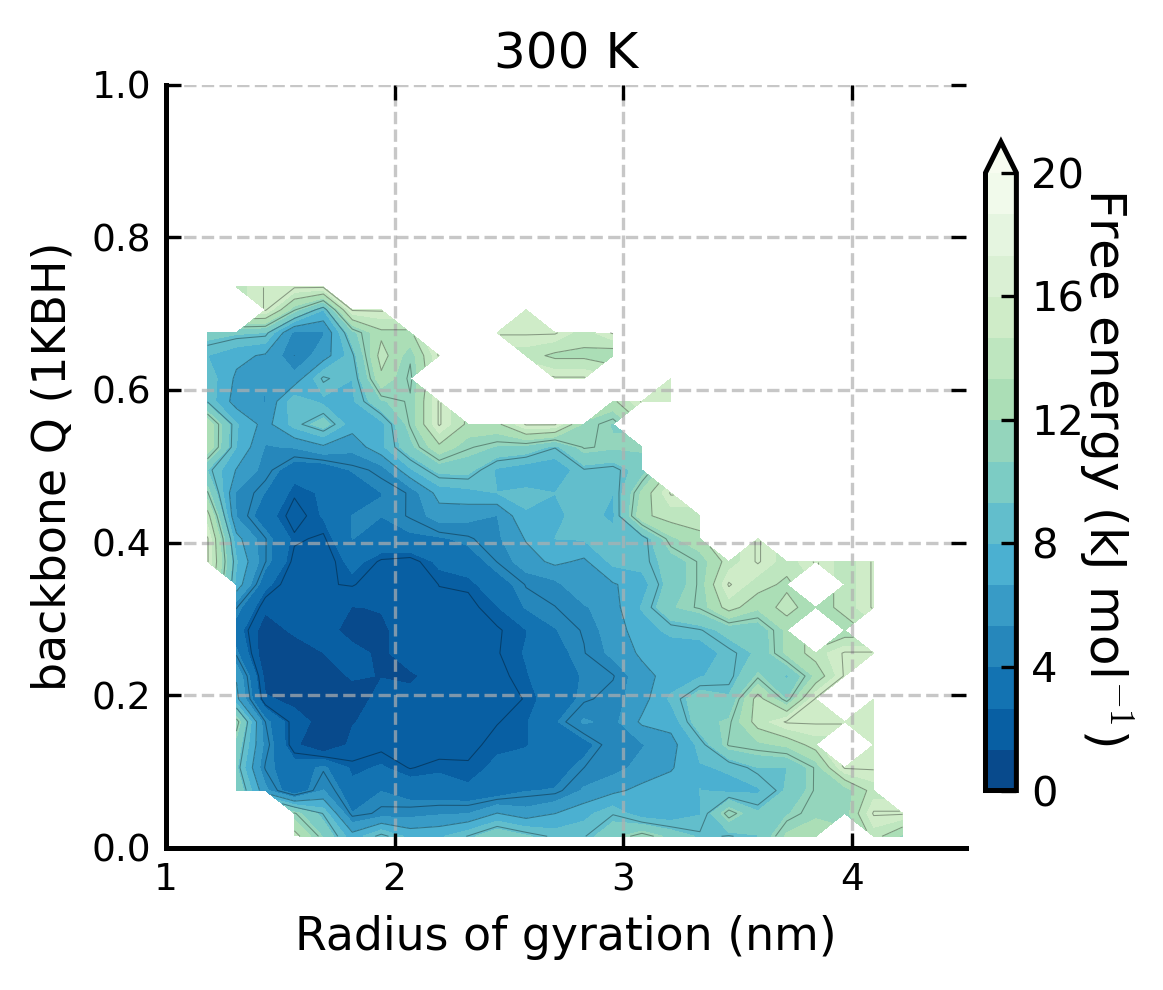

In [10]:
# 2D Map: Rg vs bb Q at 300 K
max_FEL = 20
kb=0.008314
T0 = 300
T = 300
kbt = kb*T0
nsims_unbiased = 1

for sim in range(nsims_unbiased):
    if sim==0:
        # Load data
        CVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        Q = np.loadtxt(path+f'native_contacts_BB/Q{sim}.dat')
    else:
        tmpCVS = np.loadtxt(path+f'dir{sim}/CVS_DATA')
        tmpQ = np.loadtxt(path+f'native_contacts_BB/Q{sim}.dat')
        CVS = np.concatenate((CVS, tmpCVS))
        Q = np.concatenate((Q, tmpQ))
    # Time arrays in μs
    time_data = np.arange(CVS.shape[0])*40/1e6

# extract CVs
time_data = np.arange(CVS.shape[0])*40/1e6
mask_data = time_data <= 2.0 
rg = CVS[:,1][mask_data]
Q = Q[mask_data]

# --- Compute 2D histogram ---
nbins = 25
H, xedges, yedges = np.histogram2d(rg, Q, bins=nbins, density=True)

# Avoid zeros for log
H[H <= 1e-15] = np.nan

# Convert probability to free energy (kJ/mol)
F = -kbt * np.log(H)
F = F - np.nanmin(F)  # shift minimum to 0

# Cap free energy to max FEL value
F[F > max_FEL] = max_FEL

# --- Grid centers for plotting ---
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])

# --- Pastel color map ---
cmap = plt.cm.viridis  # you can also try 'cividis', 'Spectral_r', or 'plasma'
from matplotlib.colors import LinearSegmentedColormap
pastel_cmap = LinearSegmentedColormap.from_list(
    "pastel_viridis", [plt.cm.viridis(0.1), plt.cm.viridis(0.6), plt.cm.viridis(0.9)], N=256
)

# plot

plt.figure(figsize=(4.0, 3.4), dpi=300)

# Smoother and fewer contour levels
levels = np.linspace(0, max_FEL, 16)

# Main contour plot
contour = plt.contourf(
    xcenters, ycenters, F.T,
    levels=levels,
    cmap='GnBu_r',
    extend='max'
)

# --- Clean, sparse colorbar ---
cbar = plt.colorbar(contour, pad=0.02, shrink=0.85)
cbar.set_label(r"Free energy (kJ mol$^{-1}$)", rotation=270, labelpad=12)

# Fewer ticks (natural nice breakpoints)
cbar_ticks = np.linspace(0, max_FEL, 6)
cbar.set_ticks(cbar_ticks)

# --- Add subtle contour lines ---
plt.contour(
    xcenters, ycenters, F.T,
    levels=np.linspace(0, max_FEL, 10),
    colors='k',
    linewidths=0.25,
    alpha=0.35
)

# --- Refined axes ---
plt.xlabel(r"Radius of gyration (nm)", fontsize=11)
plt.ylabel("backbone Q (1KBH)", fontsize=11)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)

# Light padding
plt.xlim(1, 4.5)
plt.ylim(0, 1)

# Remove top & right spines (cleaner look)
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)

plt.title(f"{T} K", fontsize=12, pad=4)

plt.tight_layout()

plt.savefig(output_path + f"{prod_name}_2D_1KBH_bb_Q_vs_Rg.pdf",
            dpi=300, bbox_inches='tight')

/tmp/ipykernel_3044932/1435652070.py:92: UserWarning: The following kwargs were not used by contour: 'rasterized'
  contour = ax.contourf(
/tmp/ipykernel_3044932/1435652070.py:101: UserWarning: The following kwargs were not used by contour: 'rasterized'
  ax.contour(


Done


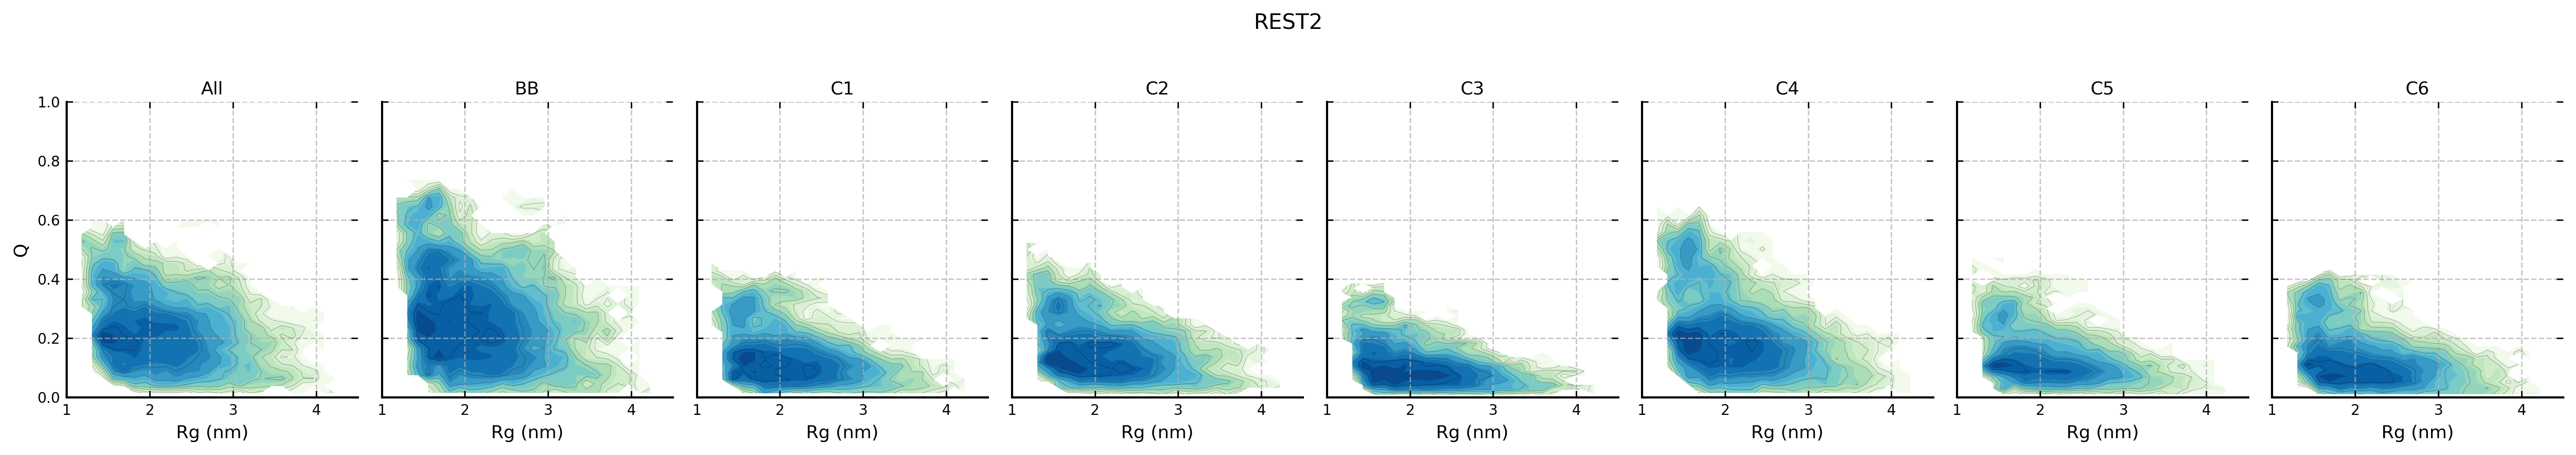

In [12]:
# FEL plots of all native contact groups


# ------------------------------------------------
# PARAMETERS
# ------------------------------------------------
max_FEL = 15
kb = 0.008314
T0 = 300
T = 300
kbt = kb * T0
nbins = 25
nsims_unbiased = 1

# ------------------------------------------------
# CONTACT DEFINITIONS + LABELS
# ------------------------------------------------
contact_defs = [
    "native_contacts",
    "native_contacts_BB",
    "native_contacts_c1",
    "native_contacts_c2",
    "native_contacts_c3",
    "native_contacts_c4",
    "native_contacts_c5",
    "native_contacts_c6",
]

contact_labels = [
    "All",
    "BB",
    "C1",
    "C2",
    "C3",
    "C4",
    "C5",
    "C6",
]

# ------------------------------------------------
# LOAD CVS + TIME (ONCE)
# ------------------------------------------------
for sim in range(nsims_unbiased):
    if sim == 0:
        CVS = np.loadtxt(path + f"dir{sim}/CVS_DATA")
    else:
        CVS = np.concatenate((CVS, np.loadtxt(path + f"dir{sim}/CVS_DATA")))

time_data = np.arange(CVS.shape[0]) * 40 / 1e6  # µs
mask_data = time_data <= 2.0

rg = CVS[:, 1][mask_data]

# ------------------------------------------------
# FIGURE SETUP: 1 ROW × 8 COLUMNS
# ------------------------------------------------
fig, axes = plt.subplots(
    1, 8,
    figsize=(20, 3.4),
    dpi=300,
    sharex=True,
    sharey=True
)

levels = np.linspace(0, max_FEL, 16)
contour_last = None

# ------------------------------------------------
# LOOP OVER CONTACT DEFINITIONS
# ------------------------------------------------
for i, (contact_dir, label) in enumerate(zip(contact_defs, contact_labels)):
    ax = axes[i]

    # Load Q
    Q = np.loadtxt(path + f"{contact_dir}/Q0.dat")
    Q = Q[mask_data]

    # 2D histogram
    H, xedges, yedges = np.histogram2d(rg, Q, bins=nbins, density=True)
    H[H <= 1e-15] = np.nan

    # Free energy
    F = -kbt * np.log(H)
    F -= np.nanmin(F)
    F[F > max_FEL] = max_FEL

    # Bin centers
    xcenters = 0.5 * (xedges[:-1] + xedges[1:])
    ycenters = 0.5 * (yedges[:-1] + yedges[1:])

    # Filled contours
    contour = ax.contourf(
        xcenters, ycenters, F.T,
        levels=levels,
        cmap="GnBu_r",
        extend="max",
        rasterized =True
    )

    # Contour lines
    ax.contour(
        xcenters, ycenters, F.T,
        levels=np.linspace(0, max_FEL, 10),
        colors="k",
        linewidths=0.25,
        alpha=0.35,
        rasterized=True
    )

    if i == len(contact_defs) - 1:
        contour_last = contour

    # Formatting
    ax.set_title(label, fontsize=10, pad=4)
    ax.set_xlim(1, 4.5)
    ax.set_ylim(0, 1)
    ax.tick_params(axis="both", labelsize=8)

    if i == 0:
        ax.set_ylabel("Q", fontsize=10)
    else:
        ax.tick_params(axis="y", labelleft=False)

    ax.set_xlabel("Rg (nm)", fontsize=10)

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)



# ------------------------------------------------
# FINALIZE
# ------------------------------------------------
fig.suptitle(f"REST2", fontsize=12, y=1.02)

plt.tight_layout()
plt.savefig(
    output_path + f"{prod_name}_2D_Q_vs_Rg_all_contacts.pdf",
    dpi=300,
    bbox_inches="tight"
)

print("Done")
